# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given cell contains a malaria parasite or not.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [20]:
cwd= os.getcwd()

In [21]:
os.chdir('/workspaces/WalkthroughProject01')
print("You set a new current directory")

You set a new current directory


In [22]:

work_dir = os.getcwd()
work_dir

'/workspaces/WalkthroughProject01'

---

## Set input directories

Set train, validation and test paths

In [23]:
my_data_dir = 'inputs/malaria_dataset/cell_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [24]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [25]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['Uninfected', 'Parasitized']


## Set image shape

In [26]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(129, 129, 3)

---

# Number of images in train, test and validation data

* train - Uninfected: 3950 images
* train - Parasitized: 3950 images
* validation - Uninfected: 564 images
* validation - Parasitized: 564 images
* test - Uninfected: 1129 images
* test - Parasitized: 1129 images




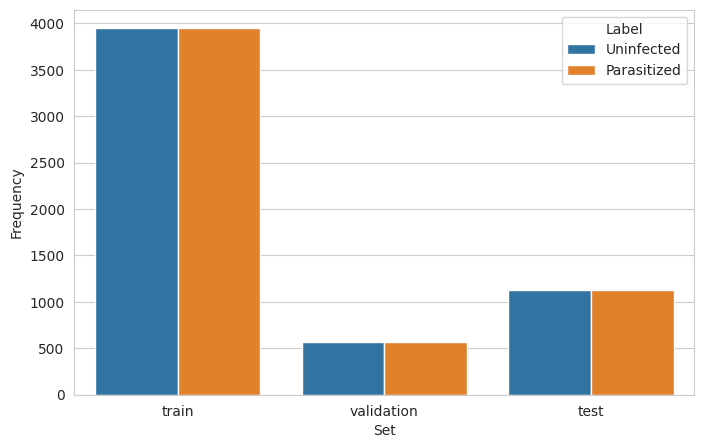

In [27]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

---

### ImageDataGenerator

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [29]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [30]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 7900 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment validation image dataset

In [31]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 1128 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment test image dataset

In [32]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 2258 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

## Plot augmented training image

(20, 129, 129, 3)


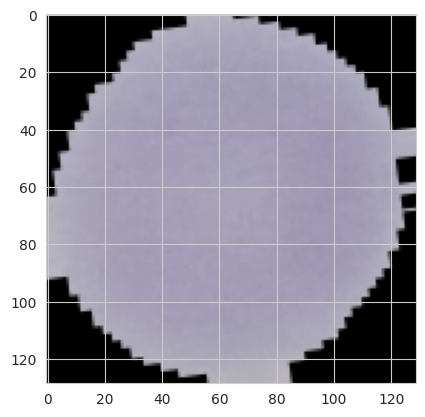

(20, 129, 129, 3)


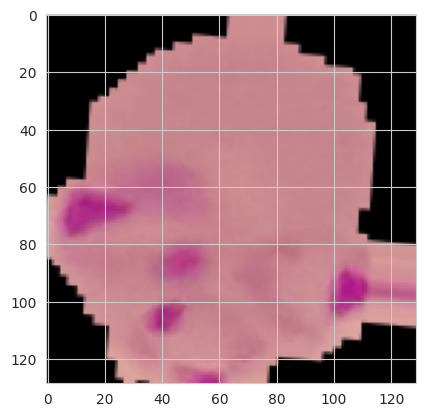

(20, 129, 129, 3)


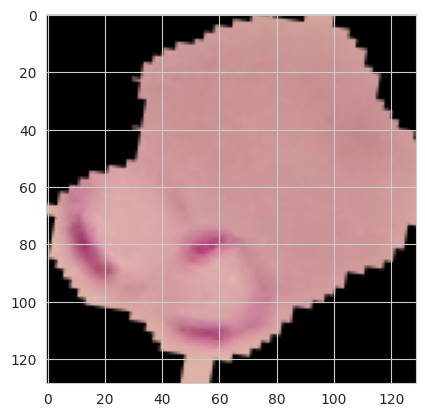

In [33]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(20, 129, 129, 3)


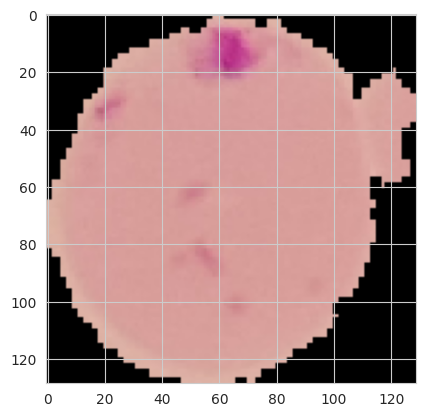

(20, 129, 129, 3)


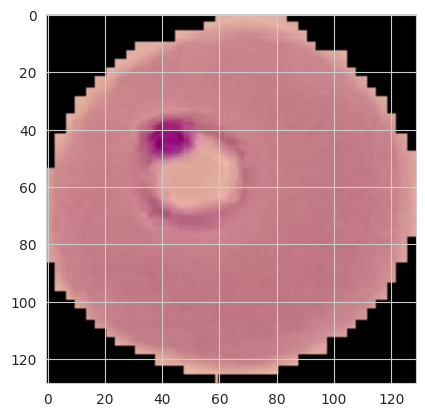

(20, 129, 129, 3)


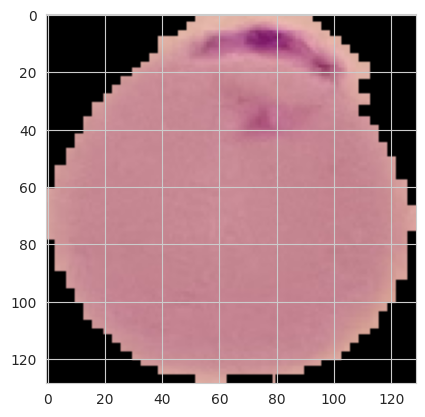

In [34]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 129, 129, 3)


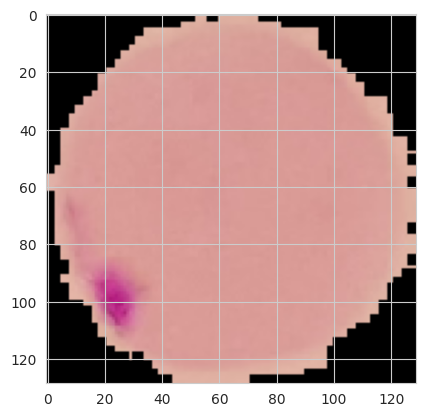

(20, 129, 129, 3)


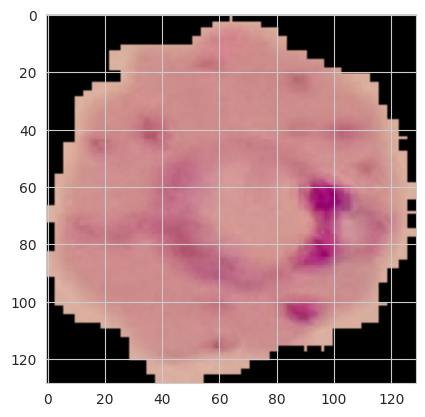

(20, 129, 129, 3)


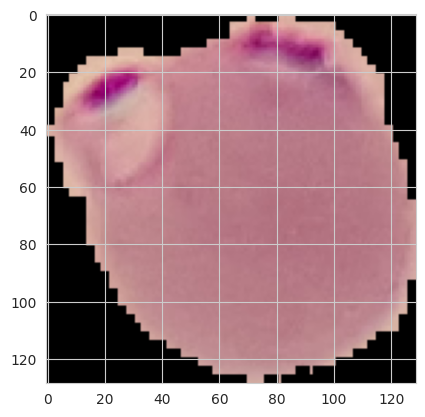

In [35]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [36]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [38]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


* ### Model Summary 

In [39]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

2023-12-10 20:03:06.077658: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Early Stopping 

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)


## Fit model for model training

In [41]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


2023-12-10 20:03:10.673917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
395/395 [==============================] - 168s 424ms/step - loss: 0.4554 - accuracy: 0.8067 - val_loss: 0.3017 - val_accuracy: 0.8901
Epoch 2/25
395/395 [==============================] - 168s 424ms/step - loss: 0.2146 - accuracy: 0.9410 - val_loss: 0.1293 - val_accuracy: 0.9699
Epoch 3/25
395/395 [==============================] - 177s 447ms/step - loss: 0.1665 - accuracy: 0.9515 - val_loss: 0.1340 - val_accuracy: 0.9654
Epoch 4/25
395/395 [==============================] - 197s 498ms/step - loss: 0.1507 - accuracy: 0.9577 - val_loss: 0.1233 - val_accuracy: 0.9690
Epoch 5/25
395/395 [==============================] - 195s 494ms/step - loss: 0.1490 - accuracy: 0.9595 - val_loss: 0.1237 - val_accuracy: 0.9672
Epoch 6/25
395/395 [==============================] - 200s 506ms/step - loss: 0.1456 - accuracy: 0.9584 - val_loss: 0.1177 - val_accuracy: 0.9725
Epoch 7/25
395/395 [==============================] - 198s 500ms/step - loss: 0.1381 - accuracy: 0.9613 - val_loss: 0.1215 -

## Save model

In [43]:
model.save('outputs/v1/malaria_detector_model.h5')

---

# Model Performace

---

## Model learning curve

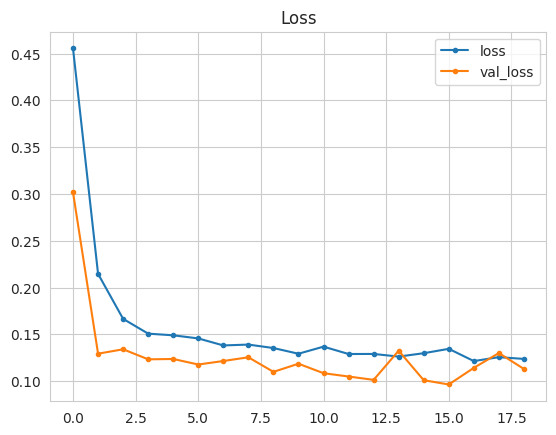

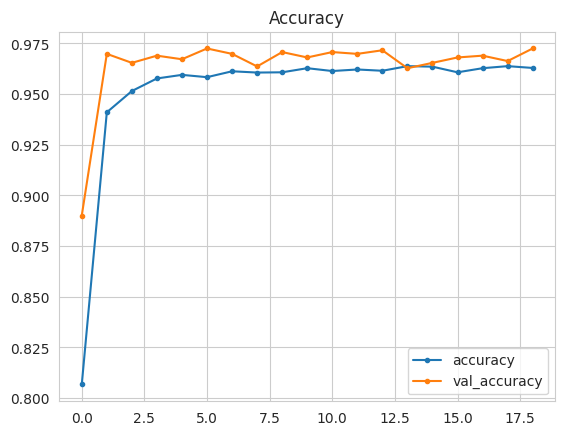

In [44]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [45]:
from keras.models import load_model
model = load_model('outputs/v1/malaria_detector_model.h5')

Evaluate model on test set

In [46]:
evaluation = model.evaluate(test_set)


113/113 [==============================] - 13s 110ms/step - loss: 0.1238 - accuracy: 0.9641


### Save evaluation pickle

In [47]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")


['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (129, 129), Image mode: RGB


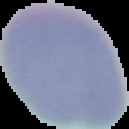

In [48]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [49]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 129, 129, 3)


Predict class probabilities

In [50]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.99870634
Uninfected


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [51]:
!cat .gitignore

inputs/malaria_dataset/cell_images/test
inputs/malaria_dataset/cell_images/train
kaggle.json
*.ipynb
__pycache__/



* Git status

In [61]:
!git status

On branch main
Your branch and 'origin/main' have diverged,
and have 2 and 1 different commits each, respectively.
  (use "git pull" to merge the remote branch into yours)

nothing to commit, working tree clean


* Git add

In [59]:
!git add .

* Git commit

In [60]:
!git commit -am " Add new plots"

[main 834122f9]  Add new plots
 1 file changed, 1329 insertions(+), 23 deletions(-)


* Git Push

In [62]:
!git push

To https://github.com/SimonPaske/WalkthroughProject01
 ! [rejected]          main -> main (non-fast-forward)
error: failed to push some refs to 'https://github.com/SimonPaske/WalkthroughProject01'
hint: Updates were rejected because the tip of your current branch is behind
hint: its remote counterpart. Integrate the remote changes (e.g.
hint: 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [58]:
!git fetch


remote: Enumerating objects: 582, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 582 (delta 8), reused 127 (delta 7), pack-reused 441
Receiving objects: 100% (582/582), 1.82 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (31/31), completed with 1 local object.
From https://github.com/SimonPaske/WalkthroughProject01
   f250a07b..73a5af63  main       -> origin/main


---